In [75]:
import os
import glob
from collections import Counter
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import os.path

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
# 10 zvierat na klasifikáciu
print(os.listdir('data/archive/raw-img'))

['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


In [65]:
# Zistenie formátov obrázkov v datasete
DATASET_PATH = "./data/archive/raw-img"

def find_image_extensions(root):
    files = glob.glob(os.path.join(root, "**", "*.*"), recursive=True)
    extensions = set()

    for file in files:
        ext = os.path.splitext(file)[1].lower()
        if ext:
            extensions.add(ext)

    return extensions

exts = find_image_extensions(DATASET_PATH)
print("Nájdené formáty:", exts)


Nájdené formáty: {'.png', '.jpeg', '.jpg'}


In [70]:
# Kontrola poškodených obrázkov
bad_images = []
image_sizes = []

for path in tqdm(image_paths):
    try:
        with Image.open(path) as img:
            img.verify()
        with Image.open(path) as img:
            image_sizes.append(img.size)
    except:
        bad_images.append(path)

print(f"\nPoškodené obrázky: {len(bad_images)}")
if bad_images:
    print("Zoznam:")
    for b in bad_images:
        print(" -", b)

100%|██████████| 26179/26179 [00:16<00:00, 1609.73it/s]


Poškodené obrázky: 0


In [71]:
def get_class_name(path):
    return os.path.basename(os.path.dirname(path))

def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df


In [79]:
# Vytvorenie DataFrame s labelmi obrazkov podla nazvu priecinka
animals_df = convert_path_to_df(DATASET_PATH)
animals_df.head()

,Filepath,Label
0,data/archive/raw-img/elefante/e032b10b2df21c22...,elefante
1,data/archive/raw-img/elefante/e130b80b2ef11c22...,elefante
2,data/archive/raw-img/elefante/e131b0072ee90021...,elefante
3,data/archive/raw-img/elefante/e132b10a2bf51c22...,elefante
4,data/archive/raw-img/elefante/e133b10d2bf21c22...,elefante


In [73]:
VALID_EXTS = ["jpg", "jpeg", "png"]

# Všetky obrázky
image_paths = []
for ext in VALID_EXTS:
    image_paths.extend(
        glob.glob(os.path.join(DATASET_PATH, "**", f"*.{ext}"), recursive=True)
    )
print("Počet obrázkov celkovo:", len(image_paths))


class_counts = Counter(get_class_name(p) for p in image_paths)
print("---Kategórie---")
for cls, cnt in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{cls}: {cnt}")


extensions = [os.path.splitext(p)[1].lower() for p in image_paths]
ext_counts = Counter(extensions)
print("---Formáty---")
for ext, cnt in sorted(ext_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{ext}: {cnt}")


Počet obrázkov celkovo: 26179
---Kategórie---
cane: 4863
ragno: 4821
gallina: 3098
cavallo: 2623
farfalla: 2112
mucca: 1866
scoiattolo: 1862
pecora: 1820
gatto: 1668
elefante: 1446
---Formáty---
.jpeg: 24209
.jpg: 1919
.png: 51


          width    height  aspect_ratio
count  26179.00  26179.00      26179.00
mean     320.04    252.63          1.31
std      196.94    148.40          0.31
min       60.00     57.00          0.29
25%      300.00    200.00          1.14
50%      300.00    225.00          1.33
75%      300.00    300.00          1.50
max     6720.00   6000.00          4.23


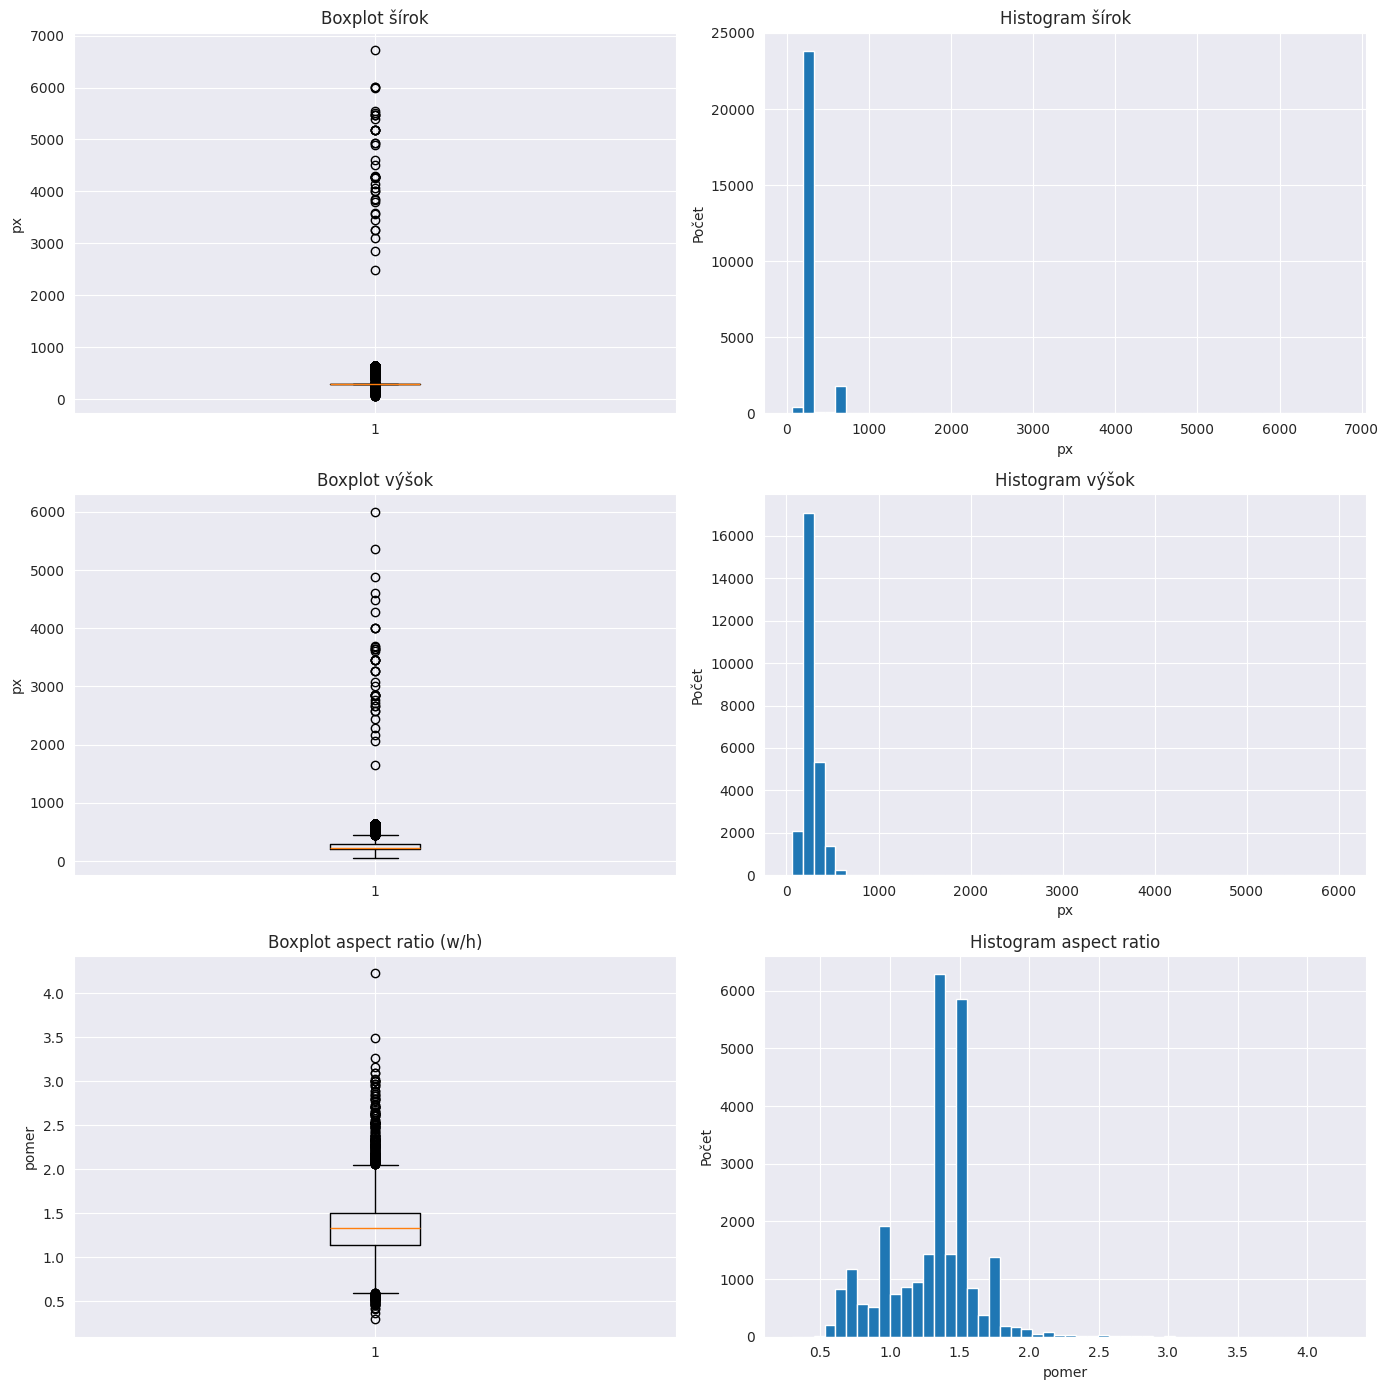

In [31]:
widths = [w for w, h in image_sizes]
heights = [h for w, h in image_sizes]
aspect_ratios = [w/h for w, h in image_sizes]

# df s šírkou, výškou a pomerom strán
df_sizes = pd.DataFrame({
    "width": widths,
    "height": heights,
    "aspect_ratio": aspect_ratios
})

print(df_sizes.describe().round(2))

fig, axs = plt.subplots(3, 2, figsize=(14, 14))

# Šírky (BOX + HIST)
axs[0, 0].boxplot(widths, vert=True)
axs[0, 0].set_title("Boxplot šírok")
axs[0, 0].set_ylabel("px")

axs[0, 1].hist(widths, bins=50)
axs[0, 1].set_title("Histogram šírok")
axs[0, 1].set_xlabel("px")
axs[0, 1].set_ylabel("Počet")


# Výšky (BOX + HIST)
axs[1, 0].boxplot(heights, vert=True)
axs[1, 0].set_title("Boxplot výšok")
axs[1, 0].set_ylabel("px")

axs[1, 1].hist(heights, bins=50)
axs[1, 1].set_title("Histogram výšok")
axs[1, 1].set_xlabel("px")
axs[1, 1].set_ylabel("Počet")


# Pomer strán (BOX + HIST)
axs[2, 0].boxplot(aspect_ratios, vert=True)
axs[2, 0].set_title("Boxplot aspect ratio (w/h)")
axs[2, 0].set_ylabel("pomer")

axs[2, 1].hist(aspect_ratios, bins=50)
axs[2, 1].set_title("Histogram aspect ratio")
axs[2, 1].set_xlabel("pomer")
axs[2, 1].set_ylabel("Počet")

plt.tight_layout()
plt.show()

In [32]:
#Zistenie farebných módov a bitovej hĺbky
bit_depths = []
modes = []

for p in tqdm(image_paths, desc="Analyzing modes"):
    try:
        with Image.open(p) as img:
            modes.append(img.mode)

            if img.mode == "RGB":
                bit_depths.append("8-bit RGB")
            elif img.mode == "RGBA":
                bit_depths.append("8-bit RGBA")
            elif img.mode == "L":
                bit_depths.append("8-bit Grayscale")
            elif img.mode == "I;16":
                bit_depths.append("16-bit Grayscale")
            else:
                bit_depths.append(f"other ({img.mode})")
    except:
        pass

print(pd.Series(modes).value_counts())
print("\nBit depth:")
print(pd.Series(bit_depths).value_counts())

Analyzing modes: 100%|██████████| 26179/26179 [00:07<00:00, 3313.80it/s]

RGB     26128
RGBA       49
L           1
CMYK        1
Name: count, dtype: int64

Bit depth:
8-bit RGB          26128
8-bit RGBA            49
8-bit Grayscale        1
other (CMYK)           1
Name: count, dtype: int64


100%|██████████| 26179/26179 [04:00<00:00, 108.91it/s]



📊 DESCRIBE RGB HISTOGRAMOV
        value            R            G            B
count  256.00       256.00       256.00       256.00
mean   127.50  10884354.67  10884354.67  10884354.67
std     74.05   3168752.01   3369265.95   5409556.79
min      0.00   5316026.00   4538744.00   4831482.00
25%     63.75   9937121.25   9317389.25   7015874.25
50%    127.50  10994075.50  11162668.00  10029472.50
75%    191.25  12139950.50  12604577.00  13708859.75
max    255.00  48167585.00  47549130.00  64925237.00


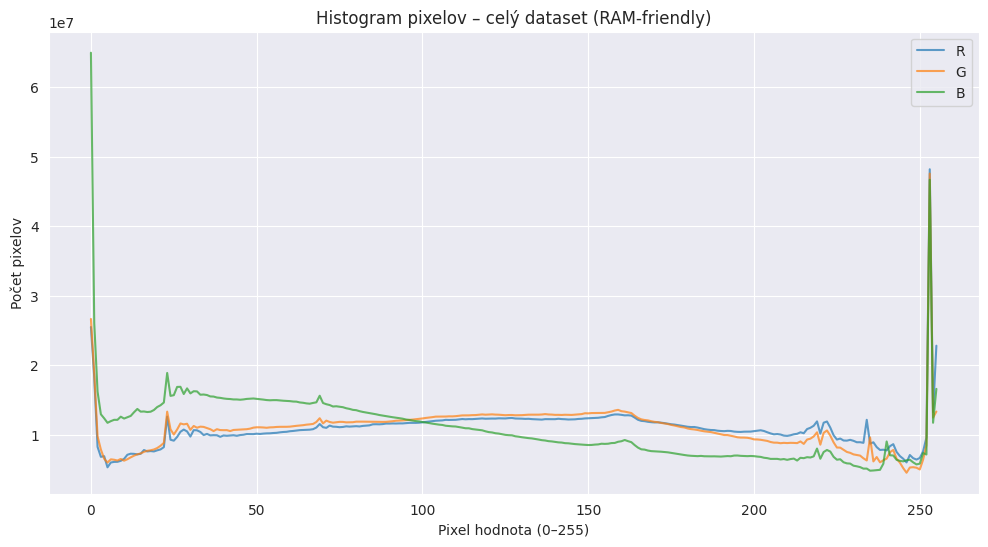

In [9]:
# Distribucia RGB pixelov
hist_R = np.zeros(256, dtype=np.int64)
hist_G = np.zeros(256, dtype=np.int64)
hist_B = np.zeros(256, dtype=np.int64)

for p in tqdm(image_paths):
    try:
        img = Image.open(p).convert("RGB")
        arr = np.array(img)

        # Histogram pre tento obrázok
        hR, _ = np.histogram(arr[:,:,0], bins=256, range=(0, 255))
        hG, _ = np.histogram(arr[:,:,1], bins=256, range=(0, 255))
        hB, _ = np.histogram(arr[:,:,2], bins=256, range=(0, 255))

        hist_R += hR
        hist_G += hG
        hist_B += hB

    except:
        pass

# DataFrame pre lepšiu prácu s dátami
df_hist = pd.DataFrame({
    "value": np.arange(256),
    "R": hist_R,
    "G": hist_G,
    "B": hist_B
})

print(df_hist.describe().round(2))

plt.figure(figsize=(12, 6))
plt.plot(df_hist["value"], df_hist["R"], label="R", alpha=0.7)
plt.plot(df_hist["value"], df_hist["G"], label="G", alpha=0.7)
plt.plot(df_hist["value"], df_hist["B"], label="B", alpha=0.7)

plt.title("Histogram pixelov – celý dataset")
plt.xlabel("Pixel hodnota (0–255)")
plt.ylabel("Počet pixelov")
plt.legend()
plt.grid(True)
plt.show()

#trva okolo 4min
#         value            R            G            B
# count  256.00       256.00       256.00       256.00
# mean   127.50  10884354.67  10884354.67  10884354.67
# std     74.05   3168752.01   3369265.95   5409556.79
# min      0.00   5316026.00   4538744.00   4831482.00
# 25%     63.75   9937121.25   9317389.25   7015874.25
# 50%    127.50  10994075.50  11162668.00  10029472.50
# 75%    191.25  12139950.50  12604577.00  13708859.75
# max    255.00  48167585.00  47549130.00  64925237.00


In [76]:
from sklearn.model_selection import train_test_split
# Data split na train a test set
train_df, test_df = train_test_split(animals_df, test_size=0.2, shuffle=True, random_state=42)

In [77]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [ ]:
 # Split the data into three categories.
TAGET_SIZE = [256,256] #[224,224]
BATCH_SIZE = 32

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


In [ ]:
# Data Augmentation
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(224,224),
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
])

2. Precission, recall, f1-score (evaluation matrcis), accuracy
3. Confusion matrix
4. ROC krivka
1. Heatmpas

- keras (resize, no aspect ratio)  vs manual (cenetering and apdding)
- ELA

Grad-CAM,EfficentNetB7